<a href="https://colab.research.google.com/github/yexf308/ATLAS/blob/main/HW/HW4/560Sp23HW4Q2_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pylab inline 
import matplotlib.gridspec as gridspec
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset


# for plotting
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['font.size'] = 16
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Populating the interactive namespace from numpy and matplotlib


# Some helper functions

In [ ]:
def show_images(images):
    images = torch.reshape(
        images, [images.shape[0], -1]
    )  # images reshape to (batch_size, D)
    sqrtn = int(math.ceil(math.sqrt(images.shape[0])))
    sqrtimg = int(math.ceil(math.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis("off")
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect("equal")
        plt.imshow(img.reshape([sqrtimg, sqrtimg]))
    return

In [ ]:
def rel_error(x, y, eps=1e-10):
    """
    Compute the relative error between a pair of tensors x and y,
    which is defined as:

                            max_i |x_i - y_i]|
    rel_error(x, y) = -------------------------------
                      max_i |x_i| + max_i |y_i| + eps

    Inputs:
    - x, y: Tensors of the same shape
    - eps: Small positive constant for numeric stability

    Returns:
    - rel_error: Scalar giving the relative error between x and y
    """
    """ returns relative error between x and y """
    top = (x - y).abs().max().item()
    bot = (x.abs() + y.abs()).clamp(min=eps).max().item()
    return top / bot

In [ ]:
def one_hot(labels, class_size):
    """
    Create one hot label matrix of size (N, C)

    Inputs:
    - labels: Labels Tensor of shape (N,) representing a ground-truth label
    for each MNIST image
    - class_size: Scalar representing of target classes our dataset
    Outputs:
    - targets: One-hot label matrix of (N, C), where targets[i, j] = 1 when
    the ground truth label for image i is j, and targets[i, :j] &
    targets[i, j + 1:] are equal to 0
    """
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return targets

In [ ]:
def train_vae(epoch, model, train_loader, cond=False):
    """
    Train a VAE or CVAE!

    Inputs:
    - epoch: Current epoch number
    - model: VAE model object
    - train_loader: PyTorch Dataloader object that contains our training data
    - cond: Boolean value representing whether we're training a VAE or
    Conditional VAE
    """
    model.train()
    train_loss = 0
    num_classes = 10
    loss = None
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device="cuda:0")
        if cond:
            one_hot_vec = one_hot(labels, num_classes).to(device="cuda")
            recon_batch, mu, logvar = model(data, one_hot_vec)
        else:
            recon_batch, mu, logvar = model(data)
        optimizer.zero_grad()
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.data
        optimizer.step()
    print("Train Epoch: {} \tLoss: {:.6f}".format(epoch, loss.data))





# Variational AutoEncoders and Conditional Variational AutoEncoder
In this homework, you will implement a variational autoencoder and a conditional variational autoencoder with slightly different architectures and apply them to the popular MNIST handwritten dataset. Recall from lecture, an autoencoder seeks to learn a latent representation of our training images by using unlabeled data and learning to reconstruct its inputs. The *variational autoencoder* extends this model by adding a probabilistic spin to the encoder and decoder, allowing us to sample from the learned distribution of the latent space to generate new images at inference time.

We will use GPUs to accelerate our computation in this notebook. Run the following to make sure GPUs are enabled:

In [ ]:
if torch.cuda.is_available():
    print('Good to go!')
else:
    print('Please set GPU via Edit -> Notebook Settings.')

## Load MNIST Dataset for Q2 and Q3


VAEs (and GANs as you'll see in the next homework) are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable, we will be working on the MNIST dataset, which has 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy. 

To simplify our code here, we will use the PyTorch MNIST wrapper, which downloads and loads the MNIST dataset. See the [documentation](https://github.com/pytorch/vision/blob/master/torchvision/datasets/mnist.py) for more information about the interface. The default parameters will take 5,000 of the training examples and place them into a validation dataset. 

In [ ]:
batch_size = 128

mnist_train = dset.MNIST('./MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size,
                          shuffle=True, drop_last=True, num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



## Visualize dataset
It is always a good idea to look at examples from the dataset before working with it. Let's visualize the digits in the MNIST dataset.

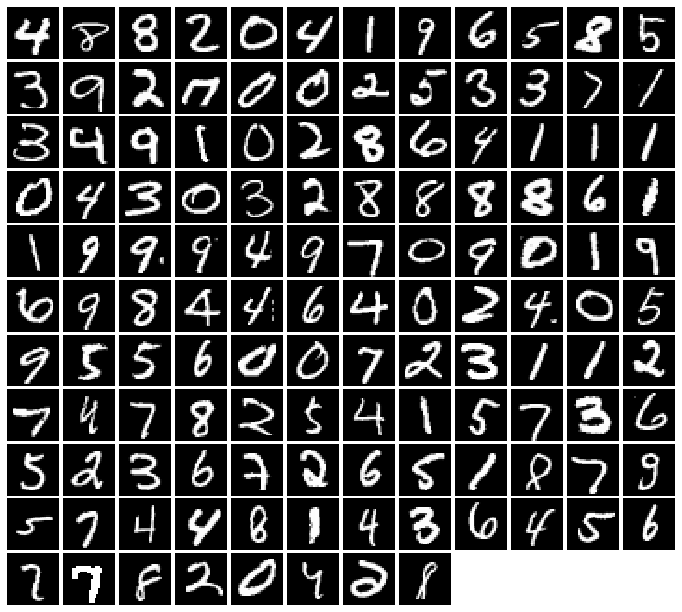

In [ ]:
imgs = loader_train.__iter__().next()[0].view(batch_size, 784)
show_images(imgs)

# Q2: Fully Connected VAE (50pt)

Our first VAE implementation will consist solely of fully connected layers. We'll take the `1 x 28 x 28` shape of our input and flatten the features to create an input dimension size of 784. In this section you'll define the Encoder and Decoder models in the VAE class of `vae` and implement the reparametrization trick, forward pass, and loss function to train your first VAE.



---


## Q2.1: Implement VAE class (20pt)

### FC-VAE Encoder

Now lets start building our fully-connected VAE network. We'll start with the encoder, which will take our images as input (after flattening $C$,$H$,$W$ to $D$ shape) and pass them through a three Linear+ReLU layers. We'll use this hidden dimension representation to predict both the posterior mu and posterior log-variance using two separate linear layers (both shape $(N,Z)$). 

Note that we are calling this the 'logvar' layer because we'll use the log-variance (instead of variance or standard deviation) to stabilize training. This will specifically matter more when you compute reparametrization and the loss function later. 

Define an `encoder`, `hidden_dim` (H), `mu_layer`, and `logvar_layer` in the initialization of the VAE class in `vae`. Use nn.Sequential to define the encoder, and separate Linear layers for the mu and logvar layers. In all of these layers, H will be a hidden dimension you set and will be the same across all encoder and decoder layers. Architecture for the encoder is described below:


 * `Flatten` (Hint: nn.Flatten)
 * Fully connected layer with input size 784 (`input_size`) and output size $H$
 * `ReLU`
 * Fully connected layer with input_size H and output size $H$
 * `ReLU`
 * Fully connected layer with input_size H and output size $H$
 * `ReLU`


### FC-VAE Decoder

We'll now define the decoder, which will take the latent space representation and generate a reconstructed image. The architecture is as follows: 

 * Fully connected layer with input size as the latent size ($Z$) and output size $H$
 * `ReLU`
 * Fully connected layer with input_size $H$ and output size $H$
 * `ReLU`
 * Fully connected layer with input_size $H$ and output size $H$
 * `ReLU`
 * Fully connected layer with input_size $H$ and output size 784 (`input_size`)
 * `Sigmoid`
 * `Unflatten` (nn.Unflatten)

Define a `decoder` in the initialization of the VAE class in `vae`. Like the encoding step, use `nn.Sequential` 


### FC-VAE Forward

Complete the VAE class by writing the forward pass. The forward pass should pass the input image through the encoder to calculate the estimation of mu and logvar, reparametrize to estimate the latent space z, and finally pass z into the decoder to generate an image.


In [ ]:
class VAE(nn.Module):
    def __init__(self, input_size, latent_size=15):
        super(VAE, self).__init__()
        self.input_size = input_size  # H*W
        self.latent_size = latent_size  # Z
        self.hidden_dim = None  # H_d
        self.encoder = None
        self.mu_layer = None
        self.logvar_layer = None
        self.decoder = None

        ###########################################################################
        # TODO: Implement the fully-connected encoder architecture described in   #
        # the notebook. Specifically, self.encoder should be a network that       #
        # inputs a batch of input images of shape (N, 1, H, W) into a batch of    #
        # hidden features of shape (N, H_d). Set up self.mu_layer and             #
        # self.logvar_layer to be a pair of linear layers that map the hidden     #
        # features into estimates of the mean and log-variance of the posterior   #
        # over the latent vectors; the mean and log-variance estimates will both  #
        # be tensors of shape (N, Z).                                             #
        ###########################################################################
        # Replace "pass" statement with your code
        pass
        ###########################################################################
        #                                      END OF YOUR CODE                   #
        ###########################################################################

    def forward(self, x):
        """
        Performs forward pass through FC-VAE model by passing image through
        encoder, reparametrize trick, and decoder models

        Inputs:
        - x: Batch of input images of shape (N, 1, H, W)

        Returns:
        - x_hat: Reconstruced input data of shape (N,1,H,W)
        - mu: Matrix representing estimated posterior mu (N, Z), with Z latent
          space dimension
        - logvar: Matrix representing estimataed variance in log-space (N, Z),
          with Z latent space dimension
        """
        x_hat = None
        mu = None
        logvar = None
        ###########################################################################
        # TODO: Implement the forward pass by following these steps               #
        # (1) Pass the input batch through the encoder model to get posterior     #
        #     mu and logvariance                                                  #
        # (2) Reparametrize to compute  the latent vector z                       #
        # (3) Pass z through the decoder to resconstruct x                        #
        ###########################################################################
        # Replace "pass" statement with your code
        pass
        ###########################################################################
        #                                      END OF YOUR CODE                   #
        ###########################################################################
        return x_hat, mu, logvar



---


## Q2.2: Implement Reparametrization (15pt)
Now we'll apply a reparametrization trick in order to estimate the posterior $z$ during our forward pass, given the $\mu$ and $\sigma^2$ estimated by the encoder. A simple way to do this could be to simply generate a normal distribution centered at our  $\mu$ and having a std corresponding to our $\sigma^2$. However, we would have to backpropogate through this random sampling that is not differentiable. Instead, we sample initial random data $\epsilon$ from a fixed distrubtion, and compute $z$ as a function of ($\epsilon$, $\sigma^2$, $\mu$). Specifically:

$z = \mu + \sigma\epsilon$

We can easily find the partial derivatives w.r.t $\mu$ and $\sigma^2$ and backpropagate through $z$. If $\epsilon = \mathcal{N} (0,1)$, then it's easy to verify that the result of our forward pass calculation will be a distribution centered at $\mu$ with variance $\sigma^2$.

Implement `reparametrization` and verify your mean and std error are at or less than `1e-4`.

In [ ]:
def reparametrize(mu, logvar):
    """
    Differentiably sample random Gaussian data with specified mean and variance
    using the reparameterization trick.

    Suppose we want to sample a random number z from a Gaussian distribution with
    mean mu and standard deviation sigma, such that we can backpropagate from the
    z back to mu and sigma. We can achieve this by first sampling a random value
    epsilon from a standard Gaussian distribution with zero mean and unit variance,
    then setting z = sigma * epsilon + mu.

    For more stable training when integrating this function into a neural network,
    it helps to pass this function the log of the variance of the distribution from
    which to sample, rather than specifying the standard deviation directly.

    Inputs:
    - mu: Tensor of shape (N, Z) giving means
    - logvar: Tensor of shape (N, Z) giving log-variances

    Returns:
    - z: Estimated latent vectors, where z[i, j] is a random value sampled from a
      Gaussian with mean mu[i, j] and log-variance logvar[i, j].
    """
    z = None
    ###############################################################################
    # TODO: Reparametrize by initializing epsilon as a normal distribution and    #
    # scaling by posterior mu and sigma to estimate z                             #
    ###############################################################################
    # Replace "pass" statement with your code
    pass
    ###############################################################################
    #                              END OF YOUR CODE                               #
    ###############################################################################
    return z

In [ ]:
np.random.seed(0)
torch.manual_seed(0)

latent_size = 15
size = (1, latent_size)
mu = torch.zeros(size)
logvar = torch.ones(size)

z = reparametrize(mu, logvar)

expected_mean = torch.FloatTensor([-0.4363])
expected_std = torch.FloatTensor([1.6860])
z_mean = torch.mean(z, dim=-1)
z_std = torch.std(z, dim=-1)
assert z.size() == size

print('Mean Error', rel_error(z_mean, expected_mean))
print('Std Error', rel_error(z_std, expected_std))



---


## Q2.3: Implement loss function (15pt)

Before we're able to train our final model, we'll need to define our loss function. As seen below, the loss function for VAEs contains two terms: A reconstruction loss term (left) and KL divergence term (right). 

\begin{align}
-E_{Z\sim q_{\phi}(z|x)}[\log p_{\theta}(x|z)] + D_{KL}(q_{\phi}(z|x), p(z)))
\end{align}

Note that this is the negative of the variational lowerbound shown in lecture--this ensures that when we are minimizing this loss term, we're maximizing the variational lowerbound. The reconstruction loss term can be computed by simply using the binary cross entropy loss between the original input pixels and the output pixels of our decoder (Hint: `nn.functional.binary_cross_entropy`). The KL divergence term works to force the latent space distribution to be close to a prior distribution (we're using a standard normal gaussian as our prior).

To help you out, we've derived an unvectorized form of the KL divergence term for you.
Suppose that $q_\phi(z|x)$ is a $Z$-dimensional diagonal Gaussian with mean $\mu_{z|x}$ of shape $(Z,)$ and standard deviation $\sigma_{z|x}$ of shape $(Z,)$, and that $p(z)$ is a $Z$-dimensional Gaussian with zero mean and unit variance. Then we can write the KL divergence term as:

\begin{align}
D_{KL}(q_{\phi}(z|x), p(z))) = -\frac{1}{2} \sum_{j=1}^{J} (1 + \log(\sigma_{z|x}^2)_{j} - (\mu_{z|x})^2_{j} - (\sigma_{z|x})^2_{j})
\end{align}

It's up to you to implement a vectorized version of this loss that also operates on minibatches.
You should average the loss across samples in the minibatch.

Implement `loss_function` and verify your implementation below. Your relative error should be less than or equal to `1e-5`

In [ ]:
def loss_function(x_hat, x, mu, logvar):
    """
    Computes the negative variational lower bound loss term of the VAE (refer to
    formulation in notebook).

    Inputs:
    - x_hat: Reconstruced input data of shape (N, 1, H, W)
    - x: Input data for this timestep of shape (N, 1, H, W)
    - mu: Matrix representing estimated posterior mu (N, Z), with Z latent space
      dimension
    - logvar: Matrix representing estimated variance in log-space (N, Z), with Z
      latent space dimension

    Returns:
    - loss: Tensor containing the scalar loss for the negative variational
      lowerbound
    """
    loss = None
    ###############################################################################
    # TODO: Compute negative variational lowerbound loss as described in the      #
    # notebook                                                                    #
    ###############################################################################
    # Replace "pass" statement with your code
    pass
    ###############################################################################
    #                            END OF YOUR CODE                                 #
    ###############################################################################
    return loss


In [ ]:
size = (1,15)

image = torch.sigmoid(torch.FloatTensor([[2,5], [6,7]]).unsqueeze(0).unsqueeze(0))
image_hat = torch.sigmoid(torch.FloatTensor([[1,10], [9,3]]).unsqueeze(0).unsqueeze(0))

expected_out = torch.tensor(8.5079)
mu, logvar = torch.ones(size), torch.zeros(size)
out = loss_function(image, image_hat, mu, logvar)
print('Loss error', rel_error(expected_out,out))


## Train a model

Now that we have our VAE defined and loss function ready, lets train our model! Our training script is provided in `train_vae` and we have pre-defined an Adam optimizer, learning rate, and # of epochs for you to use. 

Training for 10 epochs should take ~2 minutes and your loss should be less than 120.

In [ ]:
num_epochs = 10
latent_size = 15
input_size = 28*28
device = 'cuda'
vae_model = VAE(input_size, latent_size=latent_size)
vae_model.cuda()
for epoch in range(0, num_epochs):
    train_vae(epoch, vae_model, loader_train)

## Visualize results

After training our VAE network, we're able to take advantage of its power to generate new training examples. This process simply involves the decoder: we intialize some random distribution for our latent spaces z, and generate new examples by passing these latent space into the decoder. 

Run the cell below to generate new images! You should be able to visually recognize many of the digits, although some may be a bit blurry or badly formed. Our next model will see improvement in these results. 

In [ ]:
z = torch.randn(10, latent_size).to(device='cuda')
vae_model.eval()
samples = vae_model.decoder(z).data.cpu().numpy()

fig = plt.figure(figsize=(10, 1))
gspec = gridspec.GridSpec(1, 10)
gspec.update(wspace=0.05, hspace=0.05)
for i, sample in enumerate(samples):
    ax = plt.subplot(gspec[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(28,28), cmap='Greys_r')


## Latent Space Interpolation

As a final visual test of our trained VAE model, we can perform interpolation in latent space. We generate random latent vectors $z_0$ and $z_1$, and linearly interpolate between them; we run each interpolated vector through the trained generator to produce an image.

Each row of the figure below interpolates between two random vectors. For the most part the model should exhibit smooth transitions along each row, demonstrating that the model has learned something nontrivial about the underlying spatial structure of the digits it is modeling.

In [ ]:
S = 12
latent_size = 15
device = 'cuda'
z0 = torch.randn(S,latent_size , device=device)
z1 = torch.randn(S, latent_size, device=device)
w = torch.linspace(0, 1, S, device=device).view(S, 1, 1)
z = (w * z0 + (1 - w) * z1).transpose(0, 1).reshape(S * S, latent_size)
x = vae_model.decoder(z)
show_images(x.data.cpu())



---



---


# Q3: Conditional FC-VAE (15pt)

The second model you'll develop will be very similar to the FC-VAE, but with a slight conditional twist to it. We'll use what we know about the labels of each MNIST image, and *condition* our latent space and image generation on the specific class. Instead of $q_{\phi} (z|x)$ and $p_{\phi}(x|z)$ we have $q_{\phi} (z|x,c)$  and $p_{\phi}(x|z, c)$

This will allow us to do some powerful conditional generation at inference time. We can specifically choose to generate more 1s, 2s, 9s, etc. instead of simply generating new digits randomly.


## Q3.1: Implement CVAE class (15pt)
### Define Network with class input

Our CVAE architecture will be the same as our FC-VAE architecture, except we'll now add a one-hot label vector to both the x input (in our case, the flattened image dimensions) and the z latent space. 

If our one-hot vector is called `c`, then `c[label] = 1` and `c = 0` elsewhere.

For the `CVAE` class use the same FC-VAE architecture implemented in the last network with the following modifications:

1. Modify the first linear layer of your `encoder` to take in not only the flattened input image, but also the one-hot label vector `c`
2. Modify the first layer of your `decoder` to project the latent space + one-hot vector to the `hidden_dim`
3. Lastly, implement the `forward` pass to combine the flattened input image with the one-hot vectors (`torch.cat`) before passing them to the `encoder` and combine the latent space with the one-hot vectors (`torch.cat`) before passing them to the `decoder`



In [ ]:

class CVAE(nn.Module):
    def __init__(self, input_size, num_classes=10, latent_size=15):
        super(CVAE, self).__init__()
        self.input_size = input_size  # H*W
        self.latent_size = latent_size  # Z
        self.num_classes = num_classes  # C
        self.hidden_dim = None  # H_d
        self.encoder = None
        self.mu_layer = None
        self.logvar_layer = None
        self.decoder = None

        ###########################################################################
        # TODO: Define a FC encoder as described in the notebook that transforms  #
        # the image--after flattening and now adding our one-hot class vector (N, #
        # H*W + C)--into a hidden_dimension (N, H_d) feature space, and a final   #
        # two layers that project that feature space to posterior mu and posterior#
        # log-variance estimates of the latent space (N, Z)                       #
        ###########################################################################
        # Replace "pass" statement with your code
        pass

        ###########################################################################
        # TODO: Define a fully-connected decoder as described in the notebook that#
        # transforms the latent space (N, Z + C) to the estimated images of shape #
        # (N, 1, H, W).                                                           #
        ###########################################################################
        # Replace "pass" statement with your code
        pass
        ###########################################################################
        #                                      END OF YOUR CODE                   #
        ###########################################################################

    def forward(self, x, c):
        """
        Performs forward pass through FC-CVAE model by passing image through
        encoder, reparametrize trick, and decoder models

        Inputs:
        - x: Input data for this timestep of shape (N, 1, H, W)
        - c: One hot vector representing the input class (0-9) (N, C)

        Returns:
        - x_hat: Reconstructed input data of shape (N, 1, H, W)
        - mu: Matrix representing estimated posterior mu (N, Z), with Z latent
          space dimension
        - logvar: Matrix representing estimated variance in log-space (N, Z),  with
          Z latent space dimension
        """
        x_hat = None
        mu = None
        logvar = None
        ###########################################################################
        # TODO: Implement the forward pass by following these steps               #
        # (1) Pass the concatenation of input batch and one hot vectors through   #
        #     the encoder model to get posterior mu and logvariance               #
        # (2) Reparametrize to compute the latent vector z                        #
        # (3) Pass concatenation of z and one hot vectors through the decoder to  #
        #     resconstruct x                                                      #
        ###########################################################################
        # Replace "pass" statement with your code
        pass
        ###########################################################################
        #                                      END OF YOUR CODE                   #
        ###########################################################################
        return x_hat, mu, logvar


## Train model

Using the same training script, let's now train our CVAE! 

Training for 10 epochs should take ~2 minutes and your loss should be less than 120.

In [ ]:
num_epochs = 10
latent_size = 15
input_size = 28*28
device = 'cuda'

cvae = CVAE(input_size, latent_size=latent_size)
cvae.cuda()
for epoch in range(0, num_epochs):
    train_vae(epoch, cvae, loader_train, cond=True)

## Visualize Results

We've trained our CVAE, now let's conditionally generate some new data! This time, we can specify the class we want to generate by adding our one hot matrix of class labels. We use `torch.eye` to create an identity matrix, which effectively gives us one label for each digit. When you run the cell below, you should get one example per digit. Each digit should be reasonably distinguishable (it is ok to run this cell a few times to save your best results).



In [ ]:
z = torch.randn(10, latent_size)
c = torch.eye(10, 10) # [one hot labels for 0-9]
z = torch.cat((z,c), dim=-1).to(device='cuda')
cvae.eval()
samples = cvae.decoder(z).data.cpu().numpy()

fig = plt.figure(figsize=(10, 1))
gspec = gridspec.GridSpec(1, 10)
gspec.update(wspace=0.05, hspace=0.05)
for i, sample in enumerate(samples):
    ax = plt.subplot(gspec[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(28, 28), cmap='Greys_r')
